In [30]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb
from xgboost import XGBClassifier,XGBRegressor
import gc
import warnings
warnings.filterwarnings("ignore")

In [21]:
train_data=pd.read_csv("/kaggle/input/obesss/train.csv")
test_data=pd.read_csv("/kaggle/input/obesss/test.csv")
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [23]:
train_data.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [25]:
test_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,typ
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation,1
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation,1
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation,1
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation,1
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation,1


Text(0.5, 1.0, 'Test Dataset')

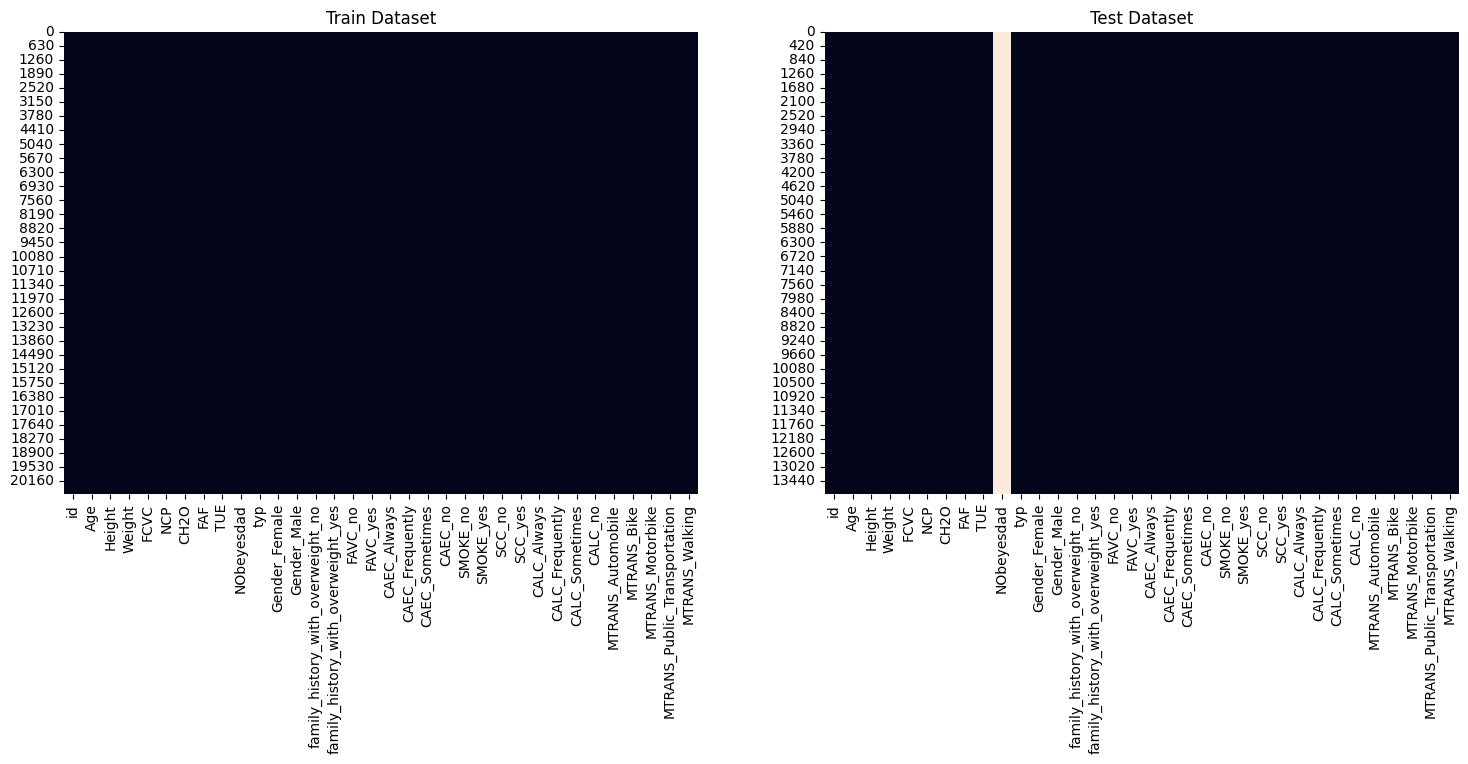

In [31]:
fig,axis=plt.subplots(1,2,figsize=(18,6))
sns.heatmap(train_data.isna(),  cbar=False, ax=axis[0])
axis[0].set_title('Train Dataset')

# Visualize null values in test dataset
sns.heatmap(test_data.isna(),  cbar=False, ax=axis[1])
axis[1].set_title('Test Dataset')

In [24]:
train_data['typ']=0
test_data['typ']=1

all=pd.concat([train_data,test_data],axis=0)
all.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,typ
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,0
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,0
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,0
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,0
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,0


In [26]:
categor = all.columns[np.where(all.dtypes == "object")[0]].drop('NObeyesdad')
cont = all.columns[np.where(all.dtypes != "object")[0]].drop(['id','typ'])
##
all=pd.get_dummies(all,columns=categor)
sc=StandardScaler()
all[cont]=sc.fit_transform(all[cont])

In [27]:
train_data = all[all.typ==0].reset_index(drop=True)
test_data = all[all.typ==1].reset_index(drop=True)

print(len(train_data))
print(len(test_data))

feat_cols=train_data.columns.drop(['id','typ','NObeyesdad'])
X_test=test_data[feat_cols]

print(feat_cols)
train_data.head()

20758
13840
Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
       'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
       'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
       'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,0.097125,0.003156,-0.228998,-0.835030,0.319748,1.202683,-1.166547,0.598886,Overweight_Level_II,...,False,False,False,True,False,False,False,False,True,False
1,1,-1.026697,-1.589647,-1.167979,-0.835030,0.343353,-0.049985,0.025192,0.637808,Normal_Weight,...,False,False,False,False,True,True,False,False,False,False
2,2,-1.026697,0.133563,-1.428102,-1.059354,-1.901298,-0.197013,-0.134447,1.752153,Insufficient_Weight,...,False,False,False,False,True,False,False,False,True,False
3,3,-0.511666,0.125258,1.659050,1.042690,0.343353,-0.584699,0.582763,0.274179,Obesity_Type_III,...,False,False,False,True,False,False,False,False,True,False
4,4,1.352648,2.440044,0.232618,0.441189,-1.110191,-0.083045,1.178764,0.524850,Overweight_Level_II,...,False,False,False,True,False,False,False,False,True,False


In [32]:
def plotdist(dataframe,target_column):
    valuecount=dataframe[target_column].value_counts()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    
    sns.barplot(x=valuecount.index,y=valuecount.values,palette='twilight',ax=ax1)
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    for index, value in enumerate(valuecount):
        ax1.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
        
    ax2.pie(valuecount, labels=valuecount.index, autopct='%1.1f%%', colors=sns.color_palette("twilight", len(valuecount)))
    ax2.axis('equal')
    fig.suptitle(f'Comparison of {target_column} ', fontsize=18)
    plt.show()

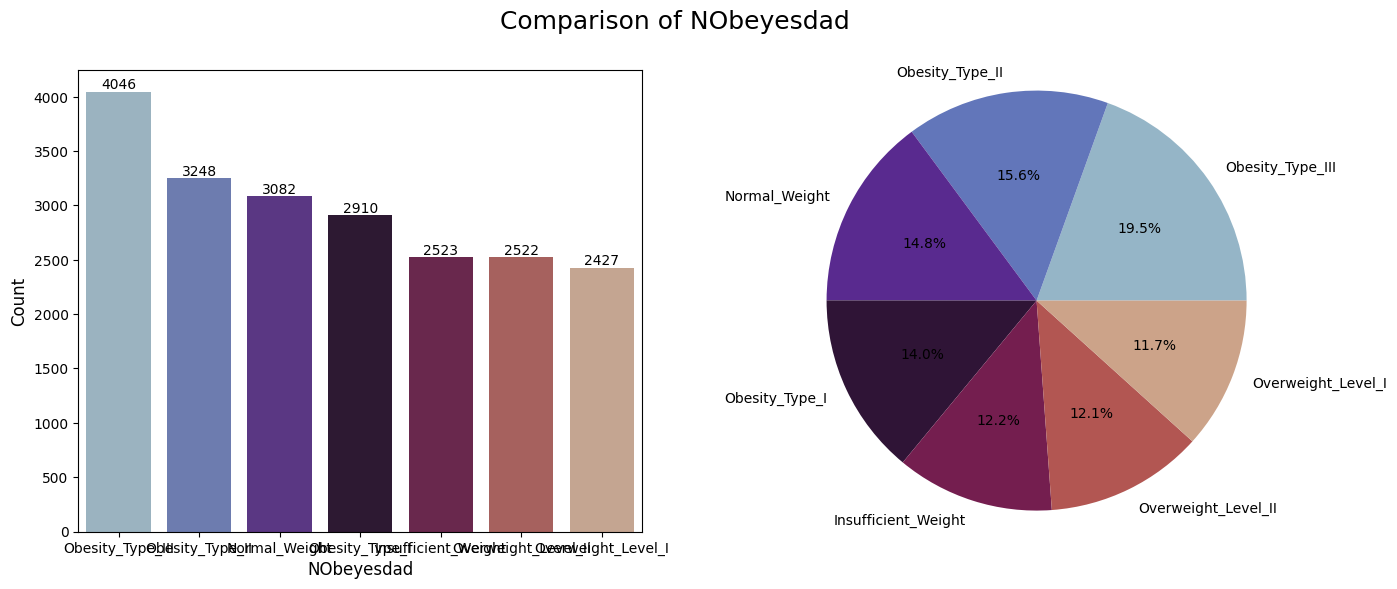

In [33]:
plotdist(train_data, 'NObeyesdad')

In [28]:
X=train_data[feat_cols]
y=train_data['NObeyesdad']
#
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [13]:
xgb_params ={
    'learning_rate': 0.026,
    'n_estimators': 1500,
    'objective':'multi:softprob',
    'eval_metric':'mlogloss',
    'early_stopping_rounds':60,
    'max_depth': 19,
    'min_child_weight': 11.7,
    'gamma': 0.40,
    'colsample_bytree': 0.46,
    'random_state':42,
    'subsample': 0.82,
    'reg_alpha': 0.0004,
    'verbosity': 0,
    'reg_lambda': 1.4,
}

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


XGB=XGBClassifier(**xgb_params)
XGB.fit(X_train,y_train, eval_set=[(X_val, y_val)],verbose=200)

y_pred_val = XGB.predict(X_val[feat_cols])
y_pred_val = y_pred_val.astype('int')
acc_val = accuracy_score(y_val, y_pred_val)
print("Accuracy : ",acc_val)

[0]	validation_0-mlogloss:1.90090
[200]	validation_0-mlogloss:0.32115
[400]	validation_0-mlogloss:0.26592
[600]	validation_0-mlogloss:0.25883
[750]	validation_0-mlogloss:0.25808
Accuracy :  0.9121708413615928


In [15]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       757
           1       0.89      0.89      0.89       925
           2       0.90      0.89      0.89       873
           3       0.96      0.98      0.97       974
           4       1.00      1.00      1.00      1214
           5       0.83      0.79      0.81       728
           6       0.82      0.84      0.83       757

    accuracy                           0.91      6228
   macro avg       0.90      0.90      0.90      6228
weighted avg       0.91      0.91      0.91      6228



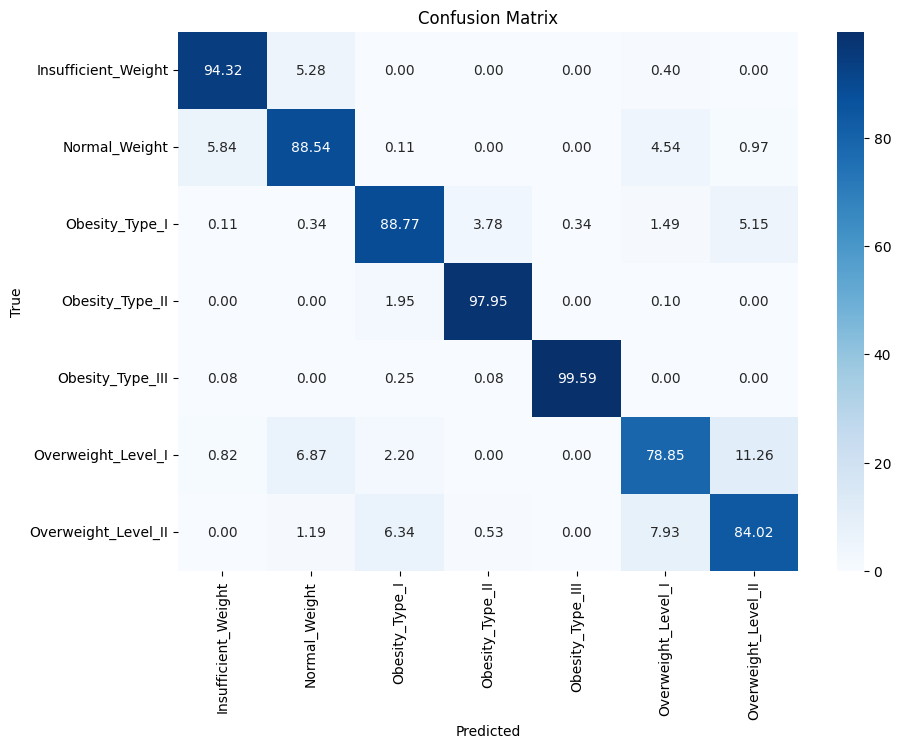

In [16]:
cm = confusion_matrix(y_val, y_pred_val)
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sb.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
          xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
y_test = XGB.predict(test_data[feat_cols])
y_test

array([3, 5, 4, ..., 0, 1, 3])

In [18]:
y_test=label_encoder.inverse_transform(y_test)
submission = test_data[['id']]
submission['NObeyesdad']=y_test
submission.to_csv("submission.csv", index=False)
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
